In [1]:
%load_ext autoreload
import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.utils.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt


2022-08-10 15:56:25.870355: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-10 15:56:25.875700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 15:56:25.875717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [2]:

num_classes = 10
input_shape = (28, 28, 1)

#### MNIST

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_ood = x_ood.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_ood = np.expand_dims(x_ood, -1)


Will also monitor scores on classifier error (because why not)

In [5]:
model = get_model("../models/save/mnist_model")
y_pred = model.predict(x_test)
maxs = np.max(y_pred, axis=1)

for i, y in enumerate(y_pred):
    for j, yy in enumerate( y):
        if yy == maxs[i]:
            y_pred[i,j] = 1
        else:
            y_pred[i,j] =  0

errors = np.sum(np.abs(y_test - y_pred), axis=1)/2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-08-10 15:57:35.989904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-10 15:57:35.989971: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-10 15:57:35.989999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-08-10 15:57:35.990251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 2s 6ms/step


## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [6]:

oodmodel = MLS(model)
scores_id = oodmodel.score(x_test)
scores_ood = oodmodel.score(x_ood)

313/313 [==============================] - 2s 6ms/step


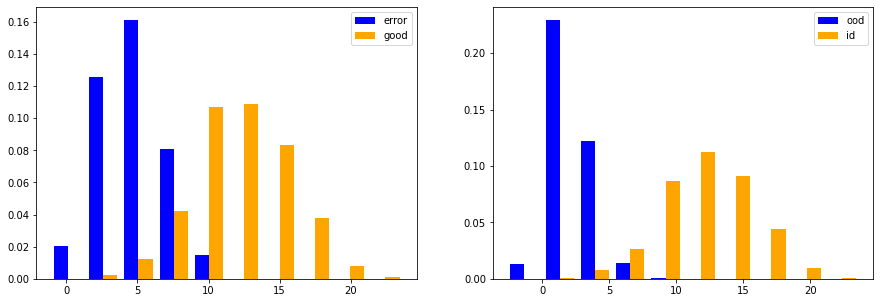

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist((scores_id[np.where(errors == 1)], scores_id[np.where(errors == 0)]), bins=10, color=("blue", "orange"), label=("error", "good"), density=True)
plt.legend()

plt.subplot(1,2,2)
plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)

plt.legend()
plt.show()

## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [9]:
%autoreload 2
oodmodel = DKNN(model)
oodmodel.fit(x_train[:20000])

625/625 [==============================] - 4s 6ms/step


In [10]:
scores_id = oodmodel.score(x_test[:1000], 30)
scores_ood = oodmodel.score(x_ood[:1000], 30)

32/32 [==============================] - 0s 6ms/step


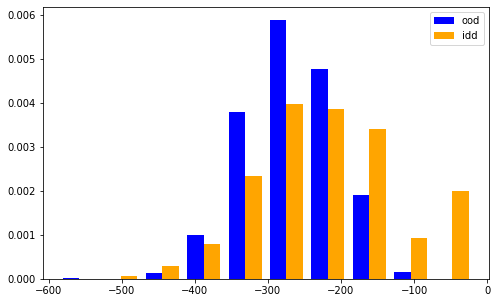

In [11]:
plt.figure(figsize=(8,5))

plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "idd"), density=True)
plt.legend()
plt.show()